# Basic ML Models of the Kaggle House Price Dataset

In [1]:
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: support for large, multi-dimensional arrays and matrices and high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, train_test_split, cross_val_score, learning_curve
print("sklearn version: {}". format(sklearn.__version__))


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.simplefilter('ignore')

pandas version: 1.4.2
numpy version: 1.21.5
sklearn version: 1.0.2


In [2]:
def load_data():
    # load prepared training and test dataset
    df_train = pd.read_pickle("../03_DataPreprocessing/df_train_prepared_reduced.pkl")
    df_test = pd.read_pickle("../03_DataPreprocessing/df_test_prepared_reduced.pkl")

    # split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
    y_train = df_train['SalePrice']
    x_train = df_train.drop(['SalePrice'], axis=1)
    x_test = df_test

    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_validate, y_validate, x_test

x_train, y_train, x_validate, y_validate, x_test = load_data()

In [3]:
x_train.columns[x_train.isna().sum() >0]

Index([], dtype='object')

In [4]:
transformer_not_num = [x for x in list(x_train) if ((x.startswith("x") & x[1].isnumeric()) | (x.endswith("_bin")))]
print(transformer_not_num)

transformer_num = [x for x in list(x_train) if x not in transformer_not_num]
print(transformer_num)

['TotalPorchSF_bin', 'GarageArea_bin', 'x0_RL', 'x0_RM', 'x2_Reg', 'x3_Lvl', 'x4_Corner', 'x4_CulDSac', 'x4_Inside', 'x5_CollgCr', 'x5_Edwards', 'x5_Gilbert', 'x5_NAmes', 'x5_NridgHt', 'x5_OldTown', 'x5_Sawyer', 'x5_Somerst', 'x6_Feedr', 'x6_Norm', 'x8_1Fam', 'x8_TwnhsE', 'x9_Hip', 'x11_HdBoard', 'x11_Plywood', 'x11_Wd Sdng', 'x12_HdBoard', 'x12_MetalSd', 'x12_Plywood', 'x12_VinylSd', 'x12_Wd Sdng', 'x13_BrkFace', 'x13_None', 'x13_Stone', 'x14_BrkTil', 'x14_CBlock', 'x14_PConc', 'x16_Y', 'x17_FuseA', 'x17_SBrkr', 'x18_Attchd', 'x18_BuiltIn', 'x18_Detchd', 'x19_WD', 'x20_Abnorml', 'x20_Normal', 'x20_Partial']
['MSSubClass', 'LotFrontage', 'LotArea', 'LandSlope', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'Half

In [5]:
# define cross validation
cv = ShuffleSplit(
    n_splits = 10,
    test_size = 0.2,
    random_state = 42
    )

In [6]:
col_transform = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), transformer_num)
    ], remainder='passthrough'
)


pipeline = Pipeline(steps=[
        ('columnprep', col_transform),
        ('reduce_dim', PCA(n_components=20)),
        ('algo', Lasso())
    ])

In [12]:
rmse_lsr = np.sqrt(-cross_val_score(pipeline, x_train, y_train, cv=cv, scoring="neg_mean_squared_error")).mean()

pipeline.fit(x_train, y_train)

pred_train = pipeline.predict(x_train)
pred_test = pipeline.predict(x_test)

<module 'matplotlib.pyplot' from 'e:\\programs\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

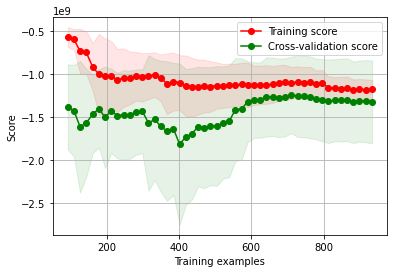

In [9]:
def plot_learning_curve(estimator, X, y, scoring, cv=None, train_sizes=np.linspace(.1, 1.0, 50)):
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.plot()

plot_learning_curve(pipeline, x_train, y_train, "neg_mean_squared_error", cv=cv)

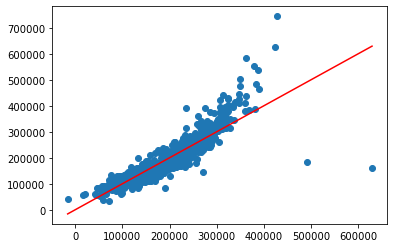

In [21]:
def plot_scatter(x_train, y_train, pred_train):
        
    plt.scatter(pred_train, y_train.values)
    plt.plot([min(pred_train), max(pred_train)], [min(pred_train), max(pred_train)], c="red")
    plt.plot()

plot_scatter(x_train, y_train, pred_train)